In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from PIL import ImageFont
import datetime

In [2]:
%matplotlib inline
mpl.style.use('seaborn')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
!rm -rf ./logs/

In [6]:
import tensorflow as tf
%load_ext tensorboard

In [7]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

cs_lo_k = {
            'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1
          }

br_ratio = {
            'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1
          }

cs_nmg = {
         'ttbar':393.30,
         'wmp'  :7.865*1e4,
         'wpwm' :74.96,
         'zwpm' :14.28,
         'n2n2' :1
         }

cs_mg = {'ttbar':5.883,
          'wmp':111.5,
          'wpwm':0.944,
          'zwpm':0.2381,
          'n2n2':3.99*1e-4
        }

cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
#k_f = [1.954,1.356,1.92,2.09,1.0]

cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [8]:
no_of_files = {'ttbar':0,
          'wmp':0,
          'wpwm':0,
          'zwpm':0,
          'n2n2':0
        }

In [9]:
df = []
for f in range(len(files)):
    con_df = []
    
    for i in range(1,53):
        try:
            con_df.append(pd.read_csv('~/neutrino/datasets/csvdata/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
            #print("Not Here : ",files[f],i)
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [10]:
tot_num = 0
for i in no_of_files.keys():
    tot_num += no_of_files[i]*1e5
    print("For the process ",i," the number of events : ",no_of_files[i]*1e5)
print('Number of Datapoints Considered : ',tot_num)

For the process  ttbar  the number of events :  4100000.0
For the process  wmp  the number of events :  4000000.0
For the process  wpwm  the number of events :  2800000.0
For the process  zwpm  the number of events :  4400000.0
For the process  n2n2  the number of events :  3900000.0
Number of Datapoints Considered :  19200000.0


In [11]:
df[-1].head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,576.562,0.232894,592.269,459.681,0.248122,475.279,36.1316,379.243,1.14509,2.253050,889.067,0.190804,0.258472,0.517955,0.670891,769.506,1.86471,4,1
1,823.599,-0.418800,896.887,339.247,-0.696095,431.789,77.3122,1052.580,2.67178,2.072780,1930.330,0.197178,0.222316,0.468612,0.544453,1113.560,1.81712,4,1
2,354.758,-1.721930,1024.200,883.807,-0.817714,1200.200,98.7750,1764.850,2.82048,0.922735,3256.570,0.328865,0.361102,0.409280,0.760725,1015.050,2.09248,4,1
3,858.275,0.386685,923.245,1258.810,0.184948,1285.290,112.0150,1546.480,1.12283,2.551460,388.116,0.216487,0.234383,0.308864,0.722296,510.332,2.04593,4,1
4,590.040,-0.006999,590.055,811.602,0.445120,897.952,90.8938,818.864,1.16291,1.495500,1133.330,0.172456,0.329166,0.461283,0.696238,351.882,3.21196,4,1


In [12]:
dtset = pd.concat(df,ignore_index=True)
dtset = shuffle(dtset)
dtset['met'] = np.fabs(dtset['met'])

In [13]:
## Analysis Level Cuts
dtset = dtset[dtset['ptl'] >= 120.0][dtset['ptj'] >= 120.0][dtset['etaj'] <= 2.0][dtset['etaj'] >= -2.0]

In [14]:
dtset.head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
1811160,183.666,-0.748592,237.577,149.638,-0.402901,162.663,15.22190,71.2538,0.546117,2.671030,302.963,0.000000,0.130607,0.320975,0.621579,122.897,1.478480,0,0
9306012,211.225,0.474553,235.459,135.461,0.845731,186.986,6.77865,151.4740,1.435020,2.357210,355.836,0.163345,0.522382,0.205986,0.406678,135.971,1.337320,3,0
747213,127.973,-0.948038,189.921,155.331,0.424858,171.965,28.64430,1296.1600,1.628960,2.857250,3342.470,0.237205,0.300216,0.301006,0.494113,152.926,0.994628,0,0
11269057,699.695,-0.729589,894.328,555.115,0.773183,735.074,90.55750,1022.8800,0.583295,2.343900,773.643,0.175866,0.285804,0.299557,0.562381,365.346,2.072490,4,1
1348840,242.668,0.273862,251.825,145.881,-0.261343,151.725,15.87990,90.7368,0.699160,0.576504,671.121,0.156544,0.230697,0.328301,0.332646,144.995,1.158270,0,0


In [15]:
train_len = int(0.8*len(dtset))
x_train = dtset.T[:-2].T[:train_len]
y_train = dtset['tag'][:train_len]

x_test = dtset.T[:-2].T[train_len:]
y_test = dtset['tag'][train_len:]

print('Shapes : ',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Shapes :  (9034704, 17) (9034704,) (2258676, 17) (2258676,)


In [16]:
callback = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="/home2/kalp_shah/tmp/backup")

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
class Significance(tf.keras.metrics.Metric):

    def __init__(self, name='significance', **kwargs):
        super(Significance, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred,type_array,sample_weight=None):
        tf.where(y_pred >= 0.7,1,y_pred)
        tf.where(y_pred < 0.7,0,y_pred)
        
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)
        
        values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        values = tf.cast(values, self.dtype)
        
        ns = tf.multiply(values,type_array[1,])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            values = tf.multiply(values, sample_weight)
        
        self.true_positives.assign( tf.cast(len(y_pred), self.dtype))

    def result(self):
        return self.true_positives

In [53]:
model = Sequential()
input_shape = x_train.shape

from keras.layers.normalization.batch_normalization import BatchNormalization
model.add(Dense(10,activation = 'relu',input_dim = input_shape[1]))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 10))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(12,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(8,activation = 'relu',input_dim = 12))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid',input_dim = 8))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
try:
    model.fit(x_train,y_train,epochs=100,batch_size=512,validation_split=0.2,
              class_weight={0:.995,1:0.005},callbacks=[callback,tensorboard_callback])
    
except:
    pass 

Epoch 1/100
14117/14117 [==============================] - 52s 4ms/step - loss: 0.0082 - accuracy: 0.7821 - val_loss: 0.6815 - val_accuracy: 0.7717
Epoch 2/100
14117/14117 [==============================] - 51s 4ms/step - loss: 0.0043 - accuracy: 0.7821 - val_loss: 0.7022 - val_accuracy: 0.7785
Epoch 3/100
14117/14117 [==============================] - 52s 4ms/step - loss: 0.0040 - accuracy: 0.7926 - val_loss: 0.5620 - val_accuracy: 0.8019
Epoch 4/100
14117/14117 [==============================] - 51s 4ms/step - loss: 0.0038 - accuracy: 0.8016 - val_loss: 0.5539 - val_accuracy: 0.8044
Epoch 5/100
14117/14117 [==============================] - 51s 4ms/step - loss: 0.0038 - accuracy: 0.8042 - val_loss: 0.5786 - val_accuracy: 0.7942
Epoch 6/100
14117/14117 [==============================] - 51s 4ms/step - loss: 0.0038 - accuracy: 0.8055 - val_loss: 0.5061 - val_accuracy: 0.8166
Epoch 7/100
14117/14117 [==============================] - 52s 4ms/step - loss: 0.0037 - accuracy: 0.8056 - val_

In [55]:
%tensorboard --logdir logs/fit --port 8008

In [56]:
tot_pred = model.predict(dtset.T[:-2].T)

In [57]:
pred_set = dtset.copy()
pred_set['pred'] = tot_pred

In [58]:
cor_pred = len(pred_set[train_len:][pred_set['pred'] >= 0.5][pred_set['tag'] == 1]) + len(pred_set[train_len:][pred_set['pred'] < 0.5][pred_set['tag'] == 0])
print('The accuracy of the test set is : ',cor_pred/(len(pred_set[train_len:])))

The accuracy of the test set is :  0.8185476801453595


In [59]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  1168464
Falsely identified signal (Flase Positive)      :  2110
Correctly identified background (True Negative) :  8071396
Falsely identified background (False Negative)  :  2051410


In [60]:
print('The amount of signal left is     :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/len(df[-1]))
print('The amount of background left is :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0])/np.sum([len(i) for i in df[:-1]]))

The amount of signal left is     : 0.35119403640027197
The amount of background left is : 0.00021914703197542146


In [61]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][dtset['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.9981974655169173


In [62]:
L = 3000

In [63]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])/(no_of_files['n2n2']*1e5))*L
print('n2n2',cs_corr['n2n2'],(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])))
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i])/((no_of_files[files[i]]*1e5)))*L
    print(files[i],len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 0.399 804393
ttbar 16 6538.845366086956
wmp 44 91227.27272727272
wpwm 199 692.2567850586979
zwpm 329 199.5908264705882


In [64]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb + ns))

The number of signal is : 246.88677461538467
The number of background is : 3279.4232232518416
The significance is : 4.157550965745204


In [65]:
model.save('/home2/kalp_shah/datasets/models/s4')

INFO:tensorflow:Assets written to: /home2/kalp_shah/datasets/models/s4/assets


In [66]:
import tensorflow_probability as tfp
cor = tfp.stats.correlation(dtset.values[:-2,:-2])

In [67]:
for i in range(len(cor)):
    for j in range(len(cor[i])):
        if cor[i,j] > 0.8 and i!=j:
            print(dtset.keys()[i],dtset.keys()[j],cor[i,j].numpy())

ptj energyj 0.8240507616760158
energyj ptj 0.8240507616760158


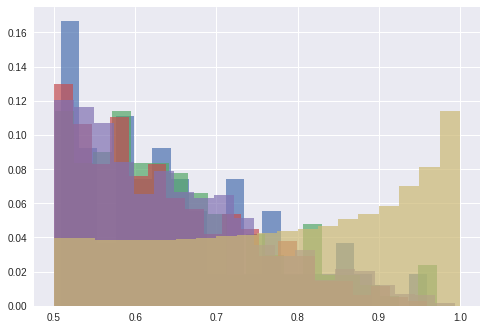

In [68]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.5]["pred"].values
    plt.hist(data,alpha=0.7,bins=20,weights=np.ones_like(data)/len(data))
plt.show()

In [53]:
pred_set[pred_set["type"] == 0]["pred"].values

array([2.5260133e-06, 9.0794361e-05, 9.8490336e-06, ..., 9.6628992e-07,
       2.2237360e-02, 1.9050436e-05], dtype=float32)